# Microtubule Tracker

Goal is to track dynacmid microtubules from seeds as a stating point.

- Input:
    - TIFF file with 2 color channels (seeds and MTs) and timepoints.
    - ImgeJ ROI ZIP file with a line for each seeds.
- Output: position of each seed and MT tips over time.

Steps are:

- Detect seed tips for all timepoints.
- Use seed tips to track dynamic MTs in the other channel.
- Convert tip positions in MT dynamic parameter.

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path

import sys; sys.path.append("../../")
import anamic

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
import read_roi

data_dir = Path("/home/hadim/Documents/Code/Postdoc/ij/testdata/anamic")

# Parameters
seed_channel_index = 1
mt_channel_index = 0

pixel_size = 107  # nm

detect_seeds = True
track_seeds = True

# TODO: Convert fitter into an object.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
fname = data_dir / "C2-T26-X154-Y132.tif"

# Load image
# TODO: make TIFF loader for huge file using `TiffFile.pages.pages` and `TiffFile.series`.
image = tifffile.imread(str(fname))

# Load ROIs
rois = read_roi.read_roi_zip(fname.with_suffix(".zip"))

In [4]:
roi = rois['0002-0063-0045']

tip_start = np.array([roi['y1'], roi['x1']])
tip_end = np.array([roi['y2'], roi['x2']])

tip_start = np.array([92, 49])
tip_end = np.array([65, 45])

xx = np.array([tip_start[0], tip_end[0]])
yy = np.array([tip_start[1], tip_end[1]])

im = image[0, seed_channel_index]

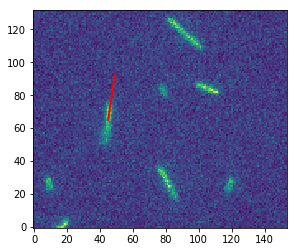

In [6]:
fig, ax = plt.subplots()
ax.imshow(image[0, seed_channel_index], interpolation='none', origin=[0, 0], cmap='viridis')
ax.plot(yy, xx, lw=2, color='red')

In [25]:
# Define fitting parameters
args = {}

args['get_thick_line_args'] = {}
args['get_thick_line_args']['length_spacing'] = 1  # pixel
args['get_thick_line_args']['line_thickness'] = 2000 / pixel_size  # pixel
args['get_thick_line_args']['width_spacing'] = 1  # pixel

args['perpendicular_line_fit_args'] = {}
args['perpendicular_line_fit_args']['length_spacing'] = 1  # pixel
args['perpendicular_line_fit_args']['fit_threshold'] = 0.5
args['perpendicular_line_fit_args']['continuous_discard'] = False

args['offset_start'] = 500 / pixel_size  # pixel
args['offset_end'] = 1000 / pixel_size  # pixel

args['tip_fit_args'] = {}
args['tip_fit_args']['length_spacing'] = 0.1  # pixel
args['tip_fit_args']['line_thickness'] = 400 / pixel_size  # pixel
args['tip_fit_args']['width_spacing'] = 0.1  # pixel

In [26]:
# Do the fitting
results = anamic.fitter.microtubule_tip_fitter(tip_start, tip_end, im, **args)
line_fit_tips, x_profile, y_profile, fit_result, fit_func = results
fit_values = fit_result.values
fit_values, fit_values['sigma'] * pixel_size

({'mu': 6.280890497920696,
  'sigma': 0.49352658191990484,
  'mt': 0.06761153733985847,
  'bg': 0.8591480246879348},
 52.80734426542982)

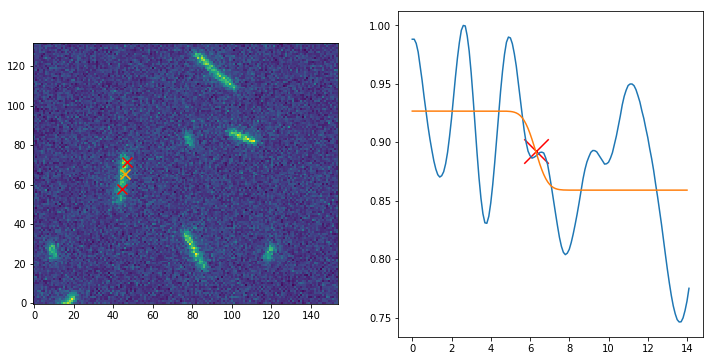

In [27]:
x = np.arange(x_profile[0], x_profile[-1], 0.1)
y_fitted = fit_func(x, **fit_values)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ax1.imshow(im, interpolation='none', origin=[0, 0], cmap='viridis')
ax1.set_aspect('equal')
ax1.scatter(line_fit_tips[:, 1], line_fit_tips[:, 0], color='red', s=100, marker="x")

ax2.plot(x_profile, y_profile, label='data')
ax2.plot(x, y_fitted, label='fit')
mu = fit_values['mu']
ax2.scatter(mu, fit_func(mu, **fit_values), color='red', s=600, marker='x')

vec = line_fit_tips[1] - line_fit_tips[0]
x, y = anamic.geometry.get_point_from_vector(vec, line_fit_tips[0], mu)
ax1.scatter(y, x, color='orange', s=100, marker='x')

In [ ]:
c = 230e-6